In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from IPython.display import display, HTML
from scipy.linalg import circulant
from scipy.linalg import toeplitz, hankel
from IPython.display import clear_output
from scipy.linalg import expm
import pickle
from matplotlib import colors


#### --------- Definition of variables ------------------------

N_size=50001 #
Gamma=0.5
Lambda=0.5

#### ------------------------------------------------------------
def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f


display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))


def Get_Bands_Matrix(N_size,Gamma=Gamma,Lambda=Lambda,beta=0.40824,mu=0,Ground =False):
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        M_minous=[((m_cos[np.abs(int(i))]-m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        M_plus = [((m_cos[np.abs(int(i))]+m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        Mminousband=np.array(M_minous)
        Mplusband=np.array(M_plus)
        
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,n=i) else 0.5 for i in x]
        m_sin=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,n=i) else 0.5 for i in x]
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)

        M_minous=[((m_cos[np.abs(int(i))]-m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        M_plus = [((m_cos[np.abs(int(i))]+m_sin[np.abs(int(i))])*0.5*np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i)))) for i in x]
        Mminousband=np.array(M_minous)
        Mplusband=np.array(M_plus)
        
    x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    Fourier_plus=fft(ifftshift(Mplusband))
    Fourier_minous=fft(ifftshift(Mminousband))
    return Fourier_plus/N_size,Fourier_minous/N_size

def Toeplitz_matrix(Fourier_plus,L):
    First_column = Fourier_plus[:L]
    First_row = np.roll(Fourier_plus,-1)[::-1][:L]
    return toeplitz(First_column,First_row)
def Hankel_matrix(Fourier_minous,L):
    to_use=Fourier_minous[:2*L-1]
    First_column=to_use[:L]
    Last_row=np.roll(to_use,-L+1)[:L]
    return hankel(First_column,Last_row)

def Covariance_matrix(L,Gamma=Gamma,Lambda=Lambda,beta=0.40824,mu=0,N_size=N_size,Ground=False):
    if Ground:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=True)
    else:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=False)
    return (Toeplitz_matrix(Fourier_plus,L)+Hankel_matrix(Fourier_minous,L))

def Covariance_matrix_from_sub_sample(Fourier_plus,Fourier_minous,L):
    return (Toeplitz_matrix(Fourier_plus,L)+Hankel_matrix(Fourier_minous,L))


def print_progress(total,step,num=50):
    message="["+"="*int(num*((step/total)))+" "*int(num*(1-(step/total)))+"]"
    message+="  "+str(round(step/total*100,3))+ " "+ "%"
    print(message,end="\r")
    
def get_band_of_matrix(Matrix,num_band):
    L,C=Matrix.shape
    if L!=C:
        raise ValueError("Only squared matrix can be computed")
    if num_band > 0:
        return np.array([[Matrix[i,j] for i in range(num_band,L) if i-j == num_band] for j in range(L-num_band)]).reshape(L-num_band)
    elif num_band <0:
        return np.array([[Matrix[i,j] for i in range(L) if i-j == num_band] for j in range(-num_band,L)]).reshape(L+num_band)
    else:
        return np.diagonal(Matrix)

In [2]:
from tqdm import tqdm_notebook as tqdm
num_data=2000
Data=np.zeros((num_data,N_size,2))
for i in tqdm(range(num_data)): 
    a,b = Get_Bands_Matrix(N_size)
    Data[i,:,0]=a.real
    Data[i,:,1]=b.real
    
with open('data_50k.pkl', 'wb') as File :
    pickle.dump(Data,File)
    File.close()


In [ ]:
with open('data_50k.pkl', 'rb') as File 
    Data_read=pickle.load(File)

# Without noise, the modes of the system

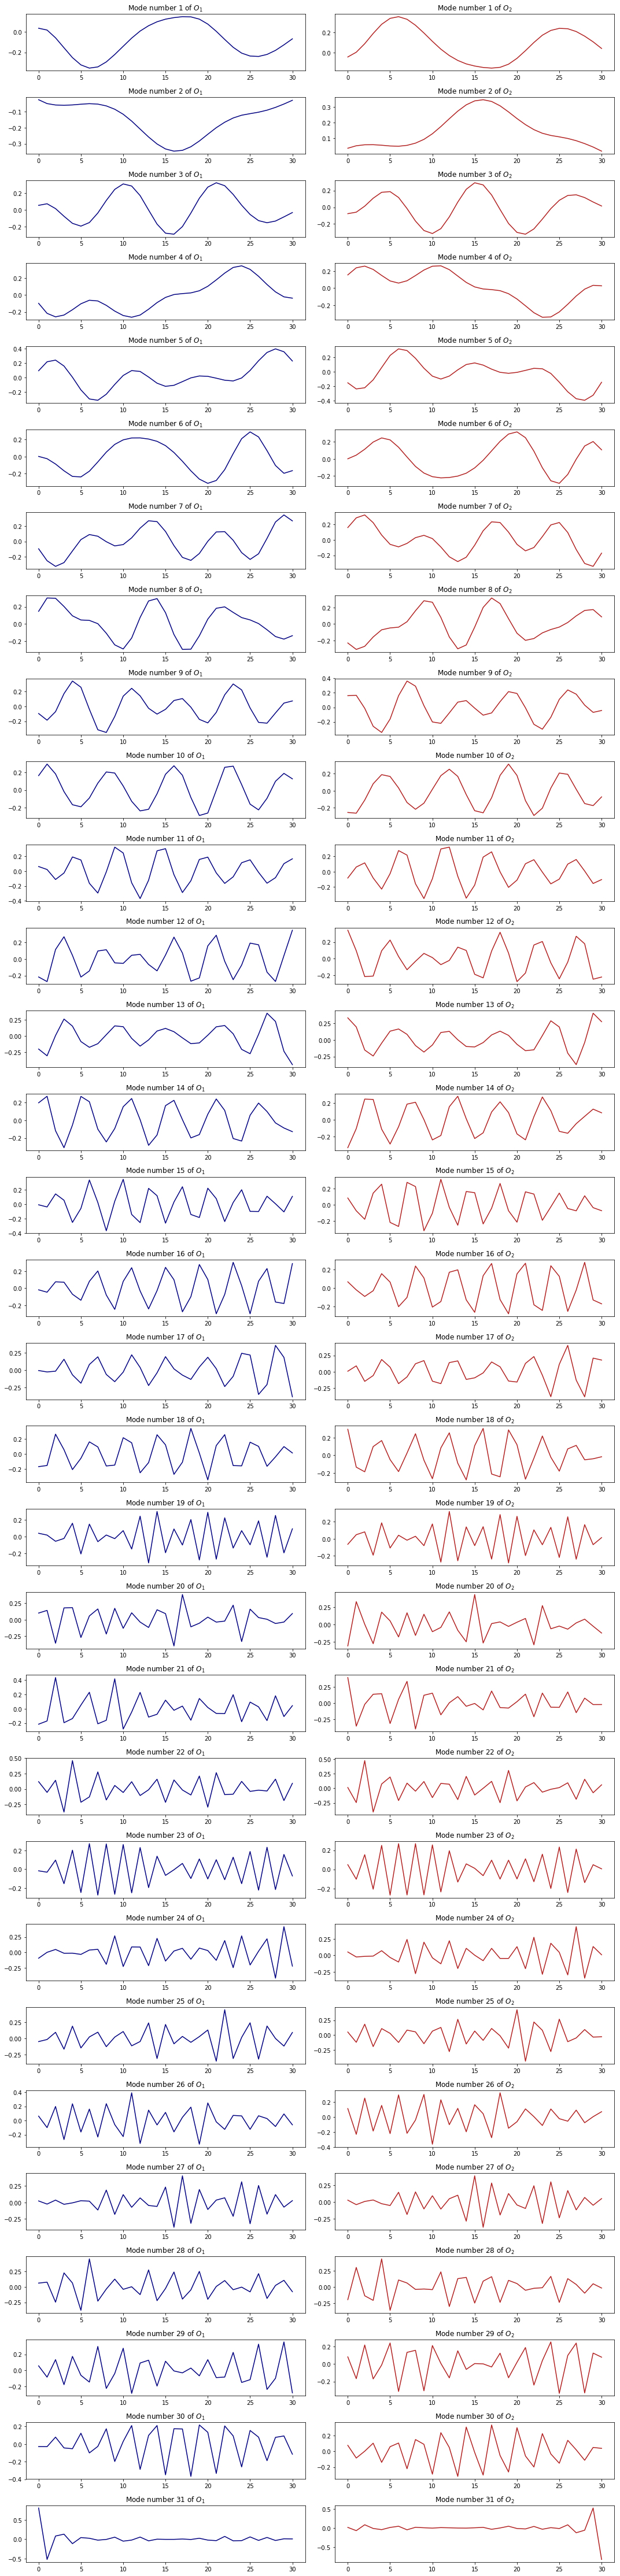

In [6]:
L=31
New_cov_matrix=Covariance_matrix_from_sub_sample(Data[1,:,0],Data[1,:,1],L)
O_1,S,O_2=np.linalg.svd(New_cov_matrix)
k=1
plt.figure(figsize=(15,int(2*L)))
for i in range(L):
    plt.subplot(L,2,k)
    k+=1
    plt.title(r"Mode number {} of $O_1$".format(i+1))
    plt.plot(O_1[:,i],color="navy")
    plt.subplot(L,2,k)
    plt.title(r"Mode number {} of $O_2$".format(i+1))
    plt.plot(O_2[i,:],color="firebrick")
    k+=1
plt.tight_layout()
plt.show()

# Getting the noise

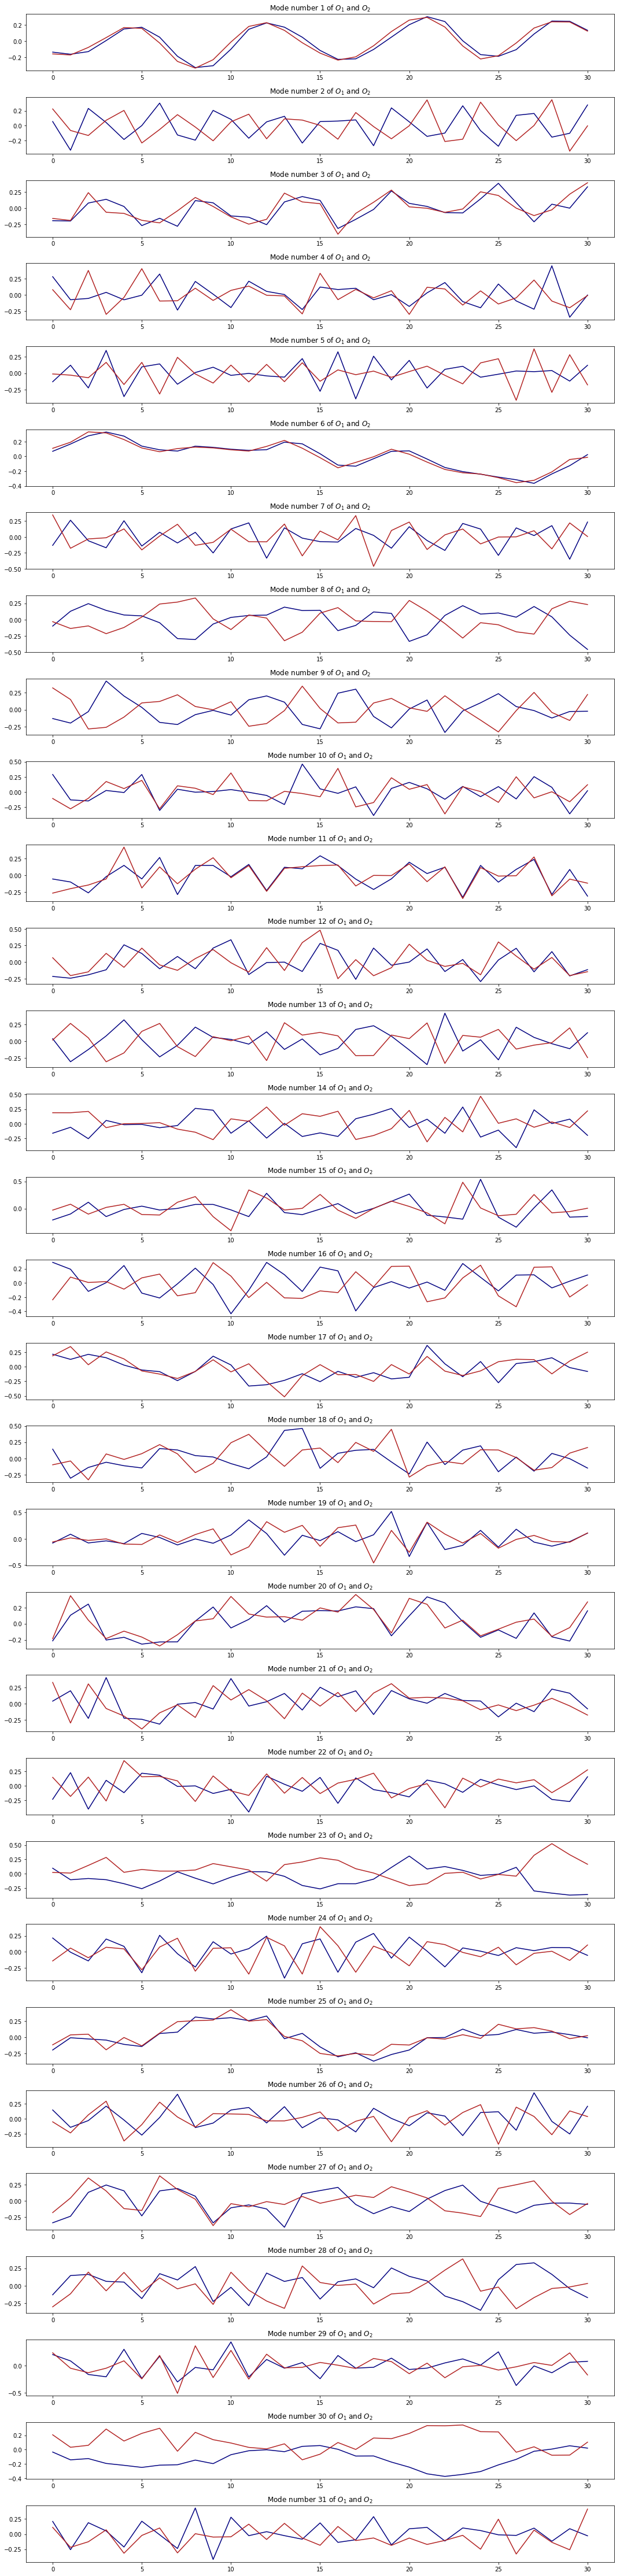

In [3]:
F_plus,F_minous=Data[:,:,0].mean(axis=0), Data[:,:,1].mean(axis=0)
F_plus_center,F_minous_center=Data[:,:,0]-F_plus, Data[:,:,1]-F_minous
L=31
New_cov_matrix=Covariance_matrix_from_sub_sample(F_plus_center[0,:],F_minous_center[0,:],L)
O_1,S,O_2=np.linalg.svd(New_cov_matrix)

k=1
plt.figure(figsize=(15,int(2*L)))
for i in range(L):
    plt.subplot(L,1,k)
    k+=1
    plt.title(r"Mode number {} of $O_1$ and $O_2$".format(i+1))
    plt.plot(O_1[:,i],color="navy")
    plt.plot(O_2[i,:],color="firebrick")
plt.tight_layout()
plt.show()

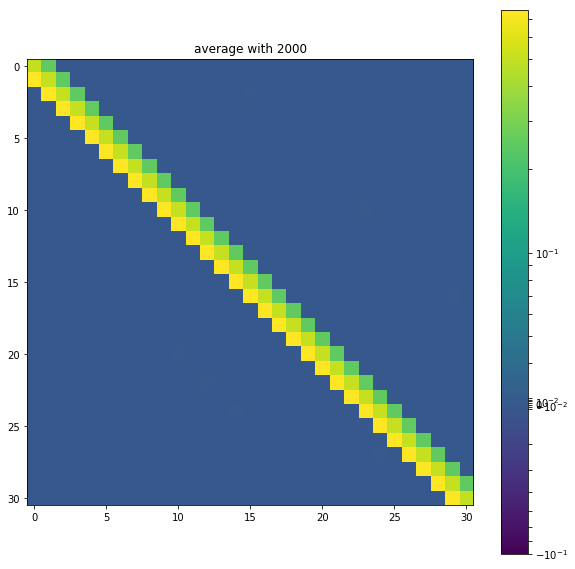

In [7]:
L=31
beta=0.40824
num_data=Data.shape[0]
M_final=np.zeros((L,L))
for i in range(num_data):
    New_cov_matrix=Covariance_matrix_from_sub_sample(Data[i,:,0],Data[i,:,1],L)
    O_1,S,O_2=np.linalg.svd(New_cov_matrix)
    S=-S+0.5
    x=np.log((1-S)/(S))
    M=(-(O_1@np.diag(x)/beta@O_2).real)
    M_final+=M
    if (i+1) % 10==0:
        clear_output(wait=True)
        plt.figure(figsize=(10,10))
        plt.title("average with {}".format(i+1))
        #mesh=plt.imshow(M_final/(i+1),cmap="RdBu_r")
        mesh=plt.imshow((M_final)/(i+1),norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03, vmin=-0.1, vmax=0.75))
        #mesh.set_clim(-0.1,0.8)
        plt.colorbar(mesh)
        plt.show()

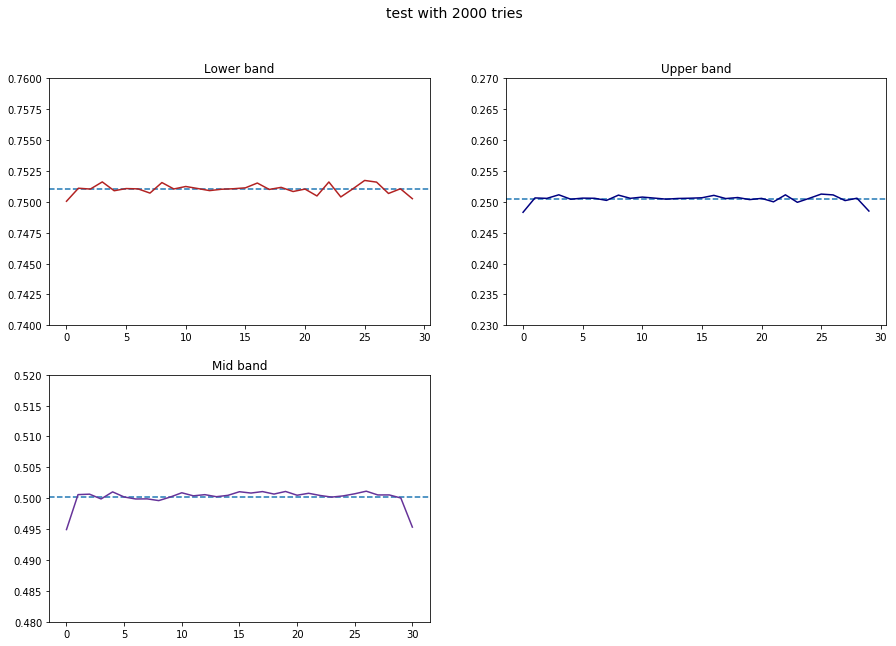

In [5]:
M_final=np.zeros((L,L))
for i in range(num_data):
    New_cov_matrix=Covariance_matrix_from_sub_sample(Data[i,:,0],Data[i,:,1],L)
    O_1,S,O_2=np.linalg.svd(New_cov_matrix)
    S=-S+0.5
    x=np.log((1-S)/(S))
    M=(-(O_1@np.diag(x)/beta@O_2).real)
    M_final+=M
    if (i+1)%50==0:
        clear_output(wait=True)
        lower_band=np.array([[M_final[i,j] for i in range(1,L) if i-j == 1] for j in range(L-1)]).reshape(L-1)/(i+1)
        upper_band=np.array([[M_final[i,j] for i in range(L) if i-j == -1] for j in range(1,L)]).reshape(L-1)/(i+1)
        diag=M_final.diagonal()/(i+1)
        fig=plt.figure(figsize=(15,10))
        fig.suptitle("test with {} tries".format(i+1), fontsize=14)
        plt.subplot(2,2,1)
        plt.title("Lower band")
        plt.axhline(y=np.mean(lower_band),linestyle="--")
        plt.plot(lower_band,color="firebrick")
        plt.ylim(0.74,0.76)
        plt.subplot(2,2,2)
        plt.title("Upper band")
        plt.axhline(y=np.mean(upper_band),linestyle="--")
        plt.plot(upper_band,color="navy")
        plt.ylim(0.23,0.27)
        plt.subplot(2,2,3)
        plt.title("Mid band")
        plt.ylim(0.48,0.52)
        plt.axhline(y=np.mean(diag),linestyle="--")
        plt.plot(diag,color="rebeccapurple")
        plt.show()

# Averganing

In [57]:
L=301
New_cov_matrix=Covariance_matrix_from_sub_sample(Data[:,:,0].mean(axis=0),Data[:,:,1].mean(axis=0),L=L)
S_2 = np.linalg.svd(New_cov_matrix.real,compute_uv=False)
M_corner=np.zeros((L,L))
M_corner[0,L-1],M_corner[L-1,0]=New_cov_matrix[1,0].real, New_cov_matrix[0,1].real
S_1 = np.linalg.svd(New_cov_matrix.real+M_corner,compute_uv=False)

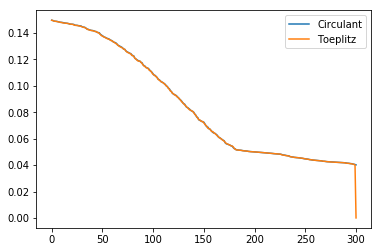

In [58]:
plt.plot(S_1,label="Circulant")
plt.plot(S_2,label="Toeplitz")
plt.legend()

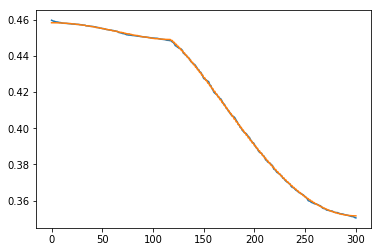

In [59]:
plt.plot(sorted(-S_1+0.5,reverse=True))
n=np.arange(-(L-1)/2,(L-1)/2 +1)
f=Fermi_dirac(beta=0.40824,mu=0,n=n,Gamma=Gamma,Lambda=Lambda,N=L)
plt.plot(sorted(f,reverse=True))

# Over a single sample

In [60]:
L=301
New_cov_matrix=Covariance_matrix_from_sub_sample(Data[1,:,0],Data[1,:,1],L=L)
S_2 = np.linalg.svd(New_cov_matrix.real,compute_uv=False)
M_corner=np.zeros((L,L))
M_corner[0,L-1],M_corner[L-1,0]=New_cov_matrix[1,0].real, New_cov_matrix[0,1].real
S_1 = np.linalg.svd(New_cov_matrix.real+M_corner,compute_uv=False)

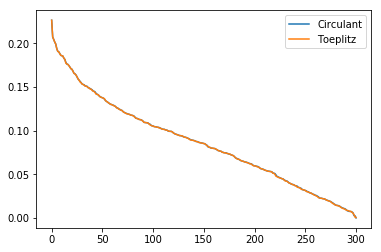

In [61]:
plt.plot(S_1,label="Circulant")
plt.plot(S_2,label="Toeplitz")
plt.legend()

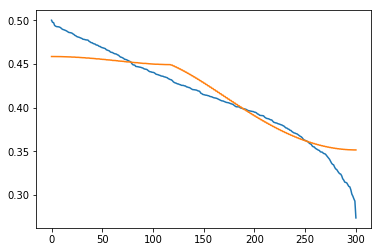

In [62]:
plt.plot(sorted(-S_1+0.5,reverse=True))
n=np.arange(-(L-1)/2,(L-1)/2 +1)
f=Fermi_dirac(beta=0.40824,mu=0,n=n,Gamma=Gamma,Lambda=Lambda,N=L)
plt.plot(sorted(f,reverse=True))

# looking at fluctuations

In [ ]:
New_cov_matrix_avg=Covariance_matrix_from_sub_sample(Data[:,:,0].mean(axis=0),Data[:,:,1].mean(axis=0),L=L)
New_cov_matrix=Covariance_matrix_from_sub_sample(Data[0,:,0],Data[0,:,1],L=L)

S_test=np.linalg.svd(New_cov_matrix-New_cov_matrix_avg,compute_uv=False)

New_cov_matrix_test=Covariance_matrix_from_sub_sample(Data[0,:,0]-Data[:,:,0].mean(axis=0),Data[0,:,1]-Data[:,:,1].mean(axis=0),L=L)

S_diff=np.linalg.svd(New_cov_matrix_test,compute_uv=False)

plt.plot(S_test)
plt.plot(S_diff)
plt.show()

std_plus,std_minous=np.mean(Data[:,:,0]-Data[:,:,0].mean(axis=0),axis=0),np.mean(Data[:,:,1]-Data[:,:,1].mean(axis=0),axis=0)

New_cov_matrix_std=Covariance_matrix_from_sub_sample(std_plus,std_minous,L=L)

S_std=np.linalg.svd(New_cov_matrix_std,compute_uv=False)

plt.plot(sorted(-S_std,reverse=True))
plt.show()

In [93]:
L=31
M=Covariance_matrix_from_sub_sample(Data[0,:,0],Data[0,:,1],L=L)
for i in range(1,2000):
    #print(i)
    M+=Covariance_matrix_from_sub_sample(Data[i,:,0],Data[i,:,1],L=L)
    S=np.linalg.svd(M,compute_uv=False)
    M_corner=np.zeros((L,L))
    M_corner[0,L-1],M_corner[L-1,0]=M[1,0].real, M[0,1].real
    S_circulant=np.linalg.svd(M+M_corner,compute_uv=False)
    if (i+1)%100==0:
        clear_output(wait=True)
        plt.plot(sorted(-S/(i+1)+0.5,reverse=True),label="Toeplitz matrix")
        plt.plot(sorted(-S_circulant/(i+1)+0.5,reverse=True),label="Circulant matrix")
        n=np.arange(-(L-1)/2,(L-1)/2 +1)
        f=Fermi_dirac(beta=0.40824,mu=0,n=n,Gamma=Gamma,Lambda=Lambda,N=L)
        plt.plot(sorted(f,reverse=True),label="Fermi dirac distribution")
        #plt.plot(S/(i+1))
        plt.title("Averaging with {} times".format(i+1))
        plt.legend()
        plt.show()

(2000, 50001, 2)